# Model Training for Package Risk Scoring

This notebook trains ML models to predict package risk.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Processed Data

In [2]:
X = pd.read_csv("data/features.csv")
y = pd.read_csv("data/labels.csv").values.ravel()

with open("data/feature_columns.json") as f:
    FEATURE_COLUMNS = json.load(f)

print(f"Features: {X.shape}")
print(f"Labels: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

Features: (100, 11)
Labels: (100,)
Class distribution: [50 50]


In [3]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 80 samples
Test set: 20 samples


In [4]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Train Random Forest (Package Risk Scorer)

In [5]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.3f}")

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

ROC-AUC: 1.000


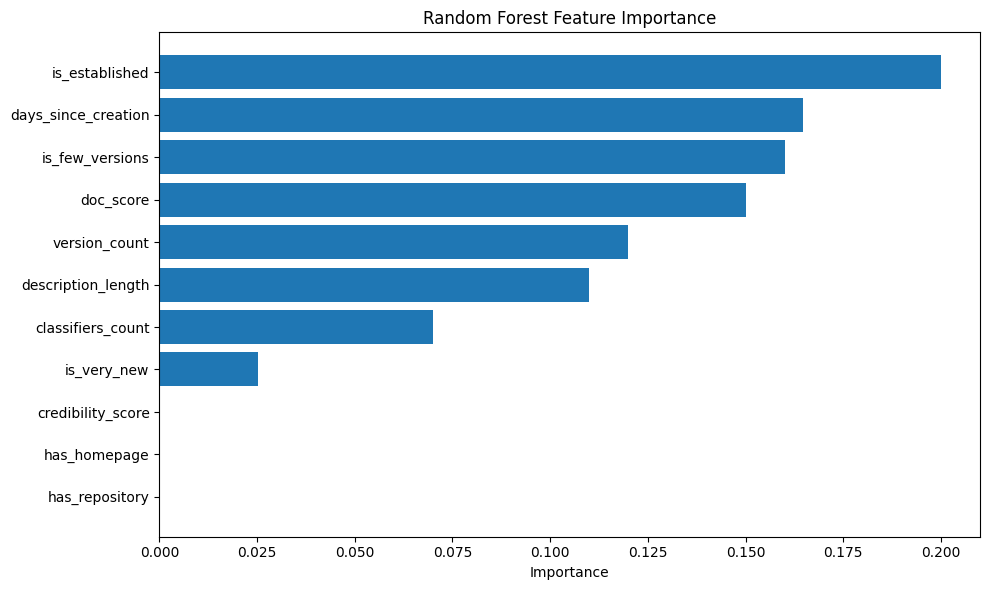

In [6]:
# Feature importance
importance = pd.DataFrame({
    "feature": FEATURE_COLUMNS,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance["feature"], importance["importance"])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig("data/feature_importance.png", dpi=150)
plt.show()

## 3. Train Logistic Regression (Typosquat Classifier)

In [7]:
# Train Logistic Regression
lr_model = LogisticRegression(
    C=1.0,
    class_weight="balanced",
    random_state=42,
    max_iter=1000
)

lr_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.3f}")

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

ROC-AUC: 1.000


## 4. Train Isolation Forest (Anomaly Detection)

In [8]:
# Train Isolation Forest on legitimate packages only
X_legitimate = X_train[y_train == 0]

iso_model = IsolationForest(
    n_estimators=100,
    contamination=0.1,  # Expected proportion of anomalies
    random_state=42,
    n_jobs=-1
)

iso_model.fit(X_legitimate)

# Evaluate
y_pred_iso = iso_model.predict(X_test)
y_pred_iso = (y_pred_iso == -1).astype(int)  # Convert -1 (anomaly) to 1

print("Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso))

Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



## 5. Cross-Validation

In [9]:
# Cross-validation scores
rf_cv = cross_val_score(rf_model, X, y, cv=5, scoring="roc_auc")
lr_cv = cross_val_score(lr_model, scaler.fit_transform(X), y, cv=5, scoring="roc_auc")

print(f"Random Forest CV ROC-AUC: {rf_cv.mean():.3f} (+/- {rf_cv.std()*2:.3f})")
print(f"Logistic Regression CV ROC-AUC: {lr_cv.mean():.3f} (+/- {lr_cv.std()*2:.3f})")

Random Forest CV ROC-AUC: 1.000 (+/- 0.000)
Logistic Regression CV ROC-AUC: 1.000 (+/- 0.000)


## 6. Confusion Matrix Visualization

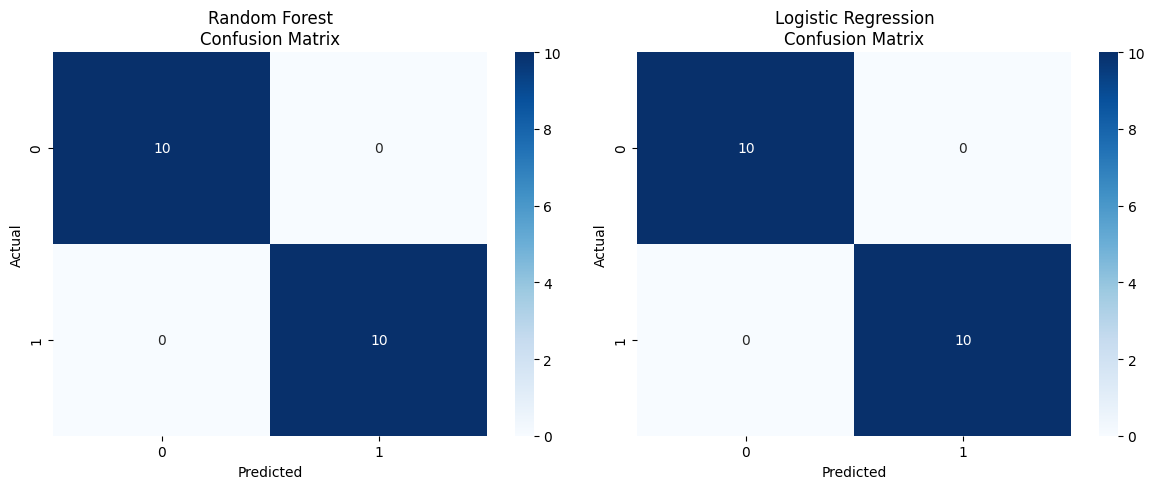

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (name, y_pred) in zip(axes, [("Random Forest", y_pred_rf), ("Logistic Regression", y_pred_lr)]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name}\nConfusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.savefig("data/confusion_matrices.png", dpi=150)
plt.show()

## Next Steps

Open `04_model_export.ipynb` to export models for production use.